In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import RFE
data = pd.read_csv('Updated_data.csv')
 
# Suppressing the ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Creating a logistic regression classifier
clf = linear_model.LogisticRegression()

# Defining the feature columns and target variable
f_cols = ['time_in_hospital','number_inpatient','number_emergency','num_medications','number_diagnoses']
X = data[f_cols]
Y = data['readmitted']

# Fitting the logistic regression model
clf.fit(X, Y)
# Printing model evaluation metrics and coefficients
print("Model score:\n {}".format(clf.score(X,Y)))
print("Intercept:\n {}".format(clf.intercept_))
print("Coefficients:\n")
for feat, coef in zip(f_cols, clf.coef_[0]):
    print(" {:>20}: {}".format(feat, coef))

Model score:
 0.8929218900675024
Intercept:
 [-2.96042358]
Coefficients:

     time_in_hospital: 0.015718362365352033
     number_inpatient: 0.27085203155630777
     number_emergency: 0.022343162999463193
      num_medications: 0.0029775567670828015
     number_diagnoses: 0.06278918387243967


In [2]:
# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split, cross_val_score, KFold
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# Creating and fitting the logistic regression model
clf = linear_model.LogisticRegression()
clf.fit(X_train, Y_train)
# Printing model scores against training and test data
print("Score against training data: {}".format(clf.score(X_train, Y_train)))
print("Score against test data: {}".format(clf.score(X_test, Y_test)))

Score against training data: 0.8932497589199614
Score against test data: 0.8923818707810993


In [3]:
# Check unique values in 'readmitted' column again
print("Unique values in 'readmitted' :", data['readmitted'].unique())
# Encode categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

Unique values in 'readmitted' : [0 1]


In [4]:
from sklearn import feature_selection

In [5]:
# Create a logistic regression model
model = linear_model.LogisticRegression()
# Define the feature matrix X0 and the target variable Y0
X0 = data.loc[:, data.columns != 'readmitted']
Y0 = data['readmitted']
# Initialize the RFE selector with a logistic regression model and select 15 featur
selector = feature_selection.RFE(model, n_features_to_select=10, step=2)
# Fit the selector to the data
selector = selector.fit(X0, Y0)
# Get the selected features based on the support_ attribute of the selector
selected_features = X0.loc[:, selector.support_]
# Print the selected features
print("Selected features:\n{}".format(',\n'.join(list(selected_features))))

Selected features:
gender,
age,
discharge_disposition_id,
number_emergency,
number_inpatient,
number_diagnoses,
A1Cresult,
metformin,
change,
diabetesMed


In [19]:
# Selecting features for the classifier
s_cols = ['time_in_hospital','number_inpatient','number_emergency','num_medications','number_diagnoses'
          'gender','age','A1Cresult','metformin','change','diabetesMed']

In [20]:
# Assigning selected features to X
X = selected_features
# Assigning the target variable 'readmitted' to Y
Y = data['readmitted']

In [21]:
# Splitting the data into training and testing sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.3, random_state=0)

In [22]:
# Creating a logistic regression classifier
clf = linear_model.LogisticRegression()

In [23]:
# Fitting the classifier to the training data
clf.fit(trainX, trainY)

LogisticRegression()

In [24]:
# Predicting the target variable for the test set
predicted = clf.predict(testX)

In [25]:
# Calculating the mean hits (proportion of correctly predicted instances)
import numpy as np
mean_hits = np.mean(predicted == testY)

In [26]:
# Calculating the accuracy score
from sklearn import metrics
accuracy_score = metrics.accuracy_score(testY, predicted)

In [27]:
# Performing 10-fold cross-validation and computing the mean scores
scores = cross_val_score(linear_model.LogisticRegression(), X, Y, scoring='accuracy', cv=10)
cross_val_mean_scores = scores.mean()

In [28]:
# Printing the mean hits, accuracy score, and cross-validation mean scores
print("Mean hits: {}".format(mean_hits))
print("Accuracy score: {}".format(accuracy_score))
print("Cross-validation mean scores: {}".format(cross_val_mean_scores))

Mean hits: 0.889817433787606
Accuracy score: 0.889817433787606
Cross-validation mean scores: 0.8928446363190548


In [29]:
def classify_for_threshold(clf, testX, testY, t):
    # Predicting probabilities for the positive class
    prob_data = pd.DataFrame(clf.predict_proba(testX)[:, 1])
    
    # Classifying based on the specified threshold
    prob_data['predict'] = np.where(prob_data[0] >= t, 1, 0)
    
    # Adding the actual labels
    prob_data['actual'] = testY
    
    # Creating a cross-tabulation of predicted vs. actual labels
    return pd.crosstab(prob_data['actual'], prob_data['predict'])

In [30]:
# Specified thresholds
thresholds = [0.05, 0.10, 0.20]
for threshold in thresholds:
    confusion_matrix = classify_for_threshold(clf, testX, testY, threshold)
    print("\nConfusion Matrix for Threshold {}: \n{}".format(threshold, confusion_matrix))


Confusion Matrix for Threshold 0.05: 
predict   0     1
actual           
0.0      43  2051
1.0       3   234

Confusion Matrix for Threshold 0.1: 
predict     0    1
actual            
0.0      1283  811
1.0       135  102

Confusion Matrix for Threshold 0.2: 
predict     0   1
actual           
0.0      2005  89
1.0       227  10


AUC = 0.6584367900386339


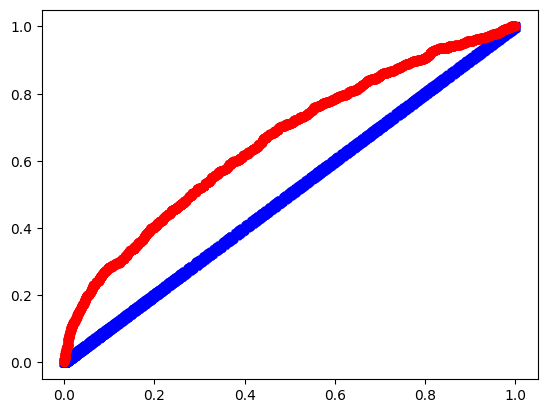

In [31]:
# Predicting probabilities for the positive class
import matplotlib.pyplot as plt
prob = np.array(clf.predict_proba(testX)[:, 1])

# Incrementing testY by 1 to convert the labels to 1 and 2
testY += 1

# Calculating the false positive rate and sensitivity (true positive rate) for ROC curve
fpr, sensitivity, _ = metrics.roc_curve(testY, prob, pos_label=2)

# Computing the Area Under Curve (AUC) for the ROC curve
print("AUC = {}".format(metrics.auc(fpr, sensitivity)))

# Plotting the ROC curve
plt.scatter(fpr, fpr, c='b', marker='s')  # Plotting the line y = x (diagonal)
plt.scatter(fpr, sensitivity, c='r', marker='o')  # Plotting the ROC curve
plt.show()